MovingPandas是一个基于Python和GeoPandas的开源地理时空数据处理库，用于处理移动物体的轨迹数据。关于MovingPandas的使用见文章：[MovingPandas入门指北](https://www.cnblogs.com/luohenyueji/p/17602916.html)，本文主要介绍三个MovingPandas的绘图实例。
MovingPandas官方仓库地址为：[movingpandas](https://github.com/movingpandas/movingpandas)。MovingPandas官方示例代码仓库地址为：[movingpandas-examples](https://github.com/movingpandas/movingpandas-examples)。本文所有实验数据来自于：[movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)。

MovingPandas作者推荐在Python 3.8及以上环境下安装MovingPandas，并建议使用conda进行安装。可以使用以下命令来安装MovingPandas：


```python
conda install -c conda-forge movingpandas
```

由于MovingPandas的依赖环境较为复杂，所以不推荐使用pip进行安装。如果坚持使用pip进行安装，可以按照以下命令来安装MovingPandas：

```python
pip install movingpandas
# 本文必安装第三方库
pip install contextily
pip install seaborn
# 以下第三方库可选
pip install hvplot
pip install cartopy
pip install geoviews
```

下面的代码展示了MovingPandas的版本信息，本文所用Python版本为Python3.10。



In [1]:
# jupyter notebook环境去除warning
import warnings
warnings.filterwarnings("ignore")

# 查看movingpandas版本及依赖库版本信息
import movingpandas as mpd
mpd.show_versions()


MovingPandas 0.16.1

SYSTEM INFO
-----------
python     : 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
executable : /opt/conda/envs/python35-paddle120-env/bin/python
machine    : Linux-5.4.0-109-generic-x86_64-with-glibc2.31

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 2.0.2
fiona      : 1.9.4.post1
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : None
hvplot     : None
geoviews   : None
stonesoup  : None


以下代码用于加载绘图所需第三方库。

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from os.path import exists
from urllib.request import urlretrieve
import contextily as cx
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}

# 1 船舶数据分析示例

船舶自动识别系统（Automatic Identification System，简称AIS）是一种用于船舶间的自动通信系统。它通过无线电信号在船舶之间传输信息，让附近的其他船舶和岸上监控站能够获得船舶的信息，如船名、船籍国、船舶类型、船舶位置、航向、航速等。本教程使用丹麦海事局发布的AIS数据，所提取的AIS记录样本涵盖了2017年7月5日哥德堡附近的船舶交通数据。本章通过对AIS数据进行轨迹数据分析，能够获得有关船舶交通有价值的见解。


**step1 加载数据**



In [3]:
# 加载数据
df = read_file('data/ais.gpkg')
# 查看数据
# Timestamp: 时间戳，指示AIS数据记录的时间。它表示了记录被创建或接收的日期和时间。
# MMSI: 船舶识别码（Maritime Mobile Service Identity），是一个唯一的数字标识符。
# NavStatus: 导航状态，指示船舶当前的导航状态或活动状态。
# SOG: 对地航速（Speed Over Ground），指船舶相对于地面的速度。
# COG: 对地航向（Course Over Ground），表示船舶相对于地面的航向。
# Name: 船名，是船舶的名称或标识符。
# ShipType: 船舶类型，表示船舶的类别或类型。
# geometry: 几何信息，表示船舶的空间位置。
df.head()

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry
0,05/07/2017 00:00:03,219632000,Under way using engine,0.0,270.4,NaN,Undefined,POINT (11.85958 57.68817)
1,05/07/2017 00:00:05,265650970,Under way using engine,0.0,0.5,NaN,Undefined,POINT (11.84175 57.66150)
2,05/07/2017 00:00:06,265503900,Under way using engine,0.0,0.0,NaN,Undefined,POINT (11.90650 57.69077)
3,05/07/2017 00:00:14,219632000,Under way using engine,0.0,188.4,NaN,Undefined,POINT (11.85958 57.68817)
4,05/07/2017 00:00:19,265519650,Under way using engine,0.0,357.2,NaN,Undefined,POINT (11.87192 57.68233)


In [4]:
# 查看数据的坐标系
df_crs = df.crs
df_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

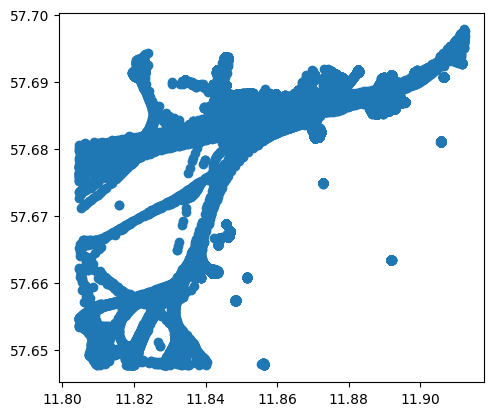

In [5]:
# 可视化数据点
df.plot()

<Axes: >

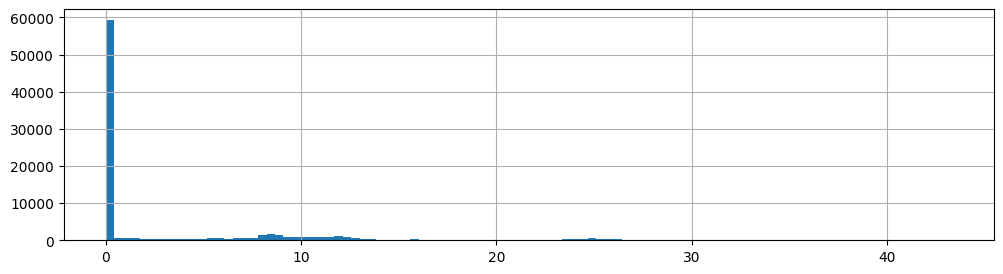

In [6]:
# 查看各船舶的对地航速
df['SOG'].hist(bins=100, figsize=(12,3))

对于数据分析，首先删除那些对地航速为0的样本：

In [7]:
# 打印数据维度
print("原始数据样本数：{}".format(len(df)))
df = df[df.SOG>0]
print("删除对地航速为0后数据样本数：{}".format(len(df)))

原始数据样本数：84702
删除对地航速为0后数据样本数：33593


查看船只有哪些类型：

<Axes: xlabel='ShipType'>

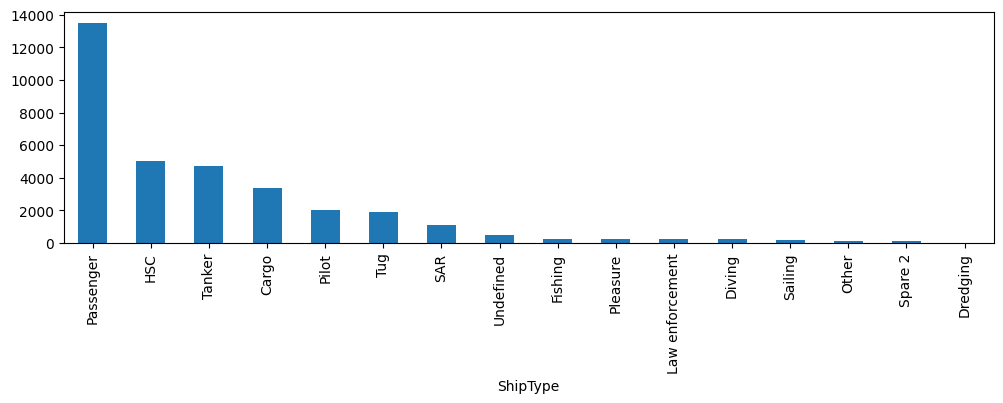

In [8]:
df['ShipType'].value_counts().plot(kind='bar', figsize=(12,3))

In [9]:
df['t'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
# 创建轨迹，轨迹数据点数最少为100
traj_collection = mpd.TrajectoryCollection(df, 'MMSI', t='t', min_length=100)
# 压缩轨迹
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(tolerance=timedelta(minutes=1))
traj_collection

TrajectoryCollection with 77 trajectories

**step2 数据可视化**

我们可以展示不同类型船只的航行轨迹。其中添加的背景地图具体使用方法见[GeoPandas叠加背景地图](https://www.cnblogs.com/luohenyueji/p/17485432.html#5-%E8%83%8C%E6%99%AF%E5%9C%B0%E5%9B%BE%E5%8F%A0%E5%8A%A0)。

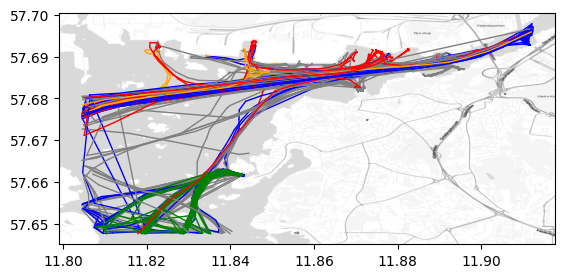

In [10]:
shiptype_to_color = {'Passenger': 'blue', 'HSC': 'green', 'Tanker': 'red', 'Cargo': 'orange'}
ax = traj_collection.plot(column='ShipType', column_to_color=shiptype_to_color, linewidth=1, capstyle='round')
# 添加背景地图,zoom越大越精细，这里使用自适应zoom。
cx.add_basemap(ax = ax , source=cx.providers.Stamen.TonerLite,crs=traj_collection.trajectories[0].crs, zoom='auto',attribution="")

<Axes: >

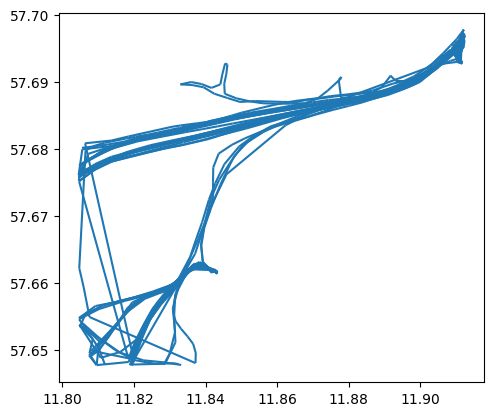

In [11]:
# 单独展示某种类型船只的航线轨迹
passenger = traj_collection.filter('ShipType', 'Passenger')
passenger.plot()

也可以单独展示某条轨迹。

In [12]:
my_traj = traj_collection.trajectories[0]
my_traj.df.head()

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry
t,,,,,,,,
2017-07-05 17:32:18,05/07/2017 17:32:18,210035000,Under way using engine,9.8,52.8,NORDIC HAMBURG,Cargo,POINT (11.80462 57.67612)
2017-07-05 17:33:18,05/07/2017 17:33:18,210035000,Under way using engine,9.5,58.9,NORDIC HAMBURG,Cargo,POINT (11.80875 57.67773)
2017-07-05 17:34:18,05/07/2017 17:34:18,210035000,Under way using engine,9.3,70.5,NORDIC HAMBURG,Cargo,POINT (11.81311 57.67879)
2017-07-05 17:35:28,05/07/2017 17:35:28,210035000,Under way using engine,9.5,71.1,NORDIC HAMBURG,Cargo,POINT (11.81855 57.67968)
2017-07-05 17:36:28,05/07/2017 17:36:28,210035000,Under way using engine,9.4,71.3,NORDIC HAMBURG,Cargo,POINT (11.82334 57.68044)


Text(0.5, 1.0, 'Trajectory 210035000')

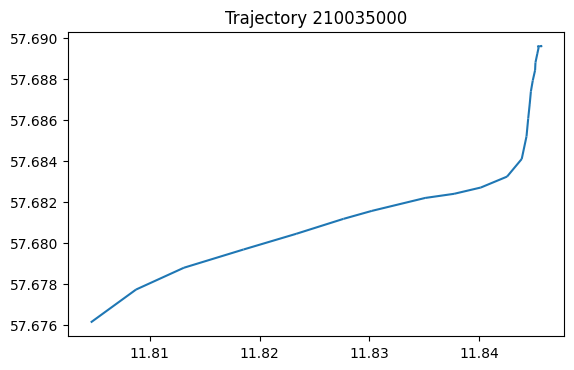

In [13]:
# 绘制该轨迹
ax = my_traj.plot() 
ax.set_title('Trajectory {}'.format(my_traj.id))

我们也可以查看感兴趣区域的轨迹。

In [14]:
area_of_interest = Polygon([(11.89935, 57.69270), (11.90161, 57.68902), (11.90334, 57.68967), (11.90104, 57.69354)
, (11.89935, 57.69270)])
# 返回与感兴趣区域相交的轨迹
intersecting = traj_collection.get_intersecting(area_of_interest)
intersecting

TrajectoryCollection with 20 trajectories

<Axes: >

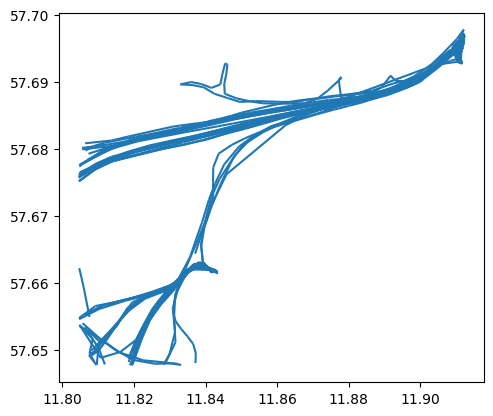

In [15]:
trips = mpd.ObservationGapSplitter(passenger).split(gap=timedelta(minutes=5))
trips.plot()

**step3 感兴趣区域分析**


我们可以确定一个感兴趣区域，如海事局。然后分析离开或达到该区域的船只时间和类型。

In [16]:
# 对于单个轨迹，如果其两个连续观测超过间隔gap，如5分钟，则认为该轨迹需要拆分为
trips = mpd.ObservationGapSplitter(traj_collection).split(gap=timedelta(minutes=5))
# 设置感兴趣区域，如海事局的坐标
area_of_interest = Polygon([(11.86815, 57.68273), (11.86992, 57.68047), (11.87419, 57.68140), (11.87288, 57.68348), (11.86815, 57.68273)])
# 获得轨迹起点在感兴趣区域的轨迹
departures = [traj for traj in trips if traj.get_start_location().intersects(area_of_interest) and traj.get_length() > 100]       

<Axes: >

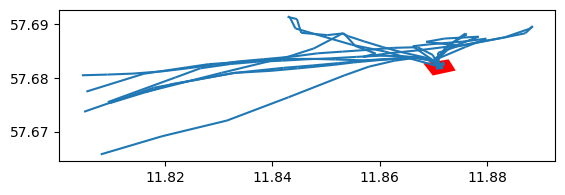

In [17]:
# 合并轨迹
tc = mpd.TrajectoryCollection(departures)
ax = tc.plot()
gpd.GeoSeries(area_of_interest).plot(ax=ax,color='red')

这样我们可以看到各艘船只从该区域出发的时间。

In [18]:
for traj in departures:
    print(f"{traj.df['ShipType'].iloc[0]} vessel '{traj.df['Name'].iloc[0]}' departed at {traj.get_start_time()}")

Law enforcement vessel 'KBV 010' departed at 2017-07-05 10:36:03
Law enforcement vessel 'KBV 010' departed at 2017-07-05 14:33:02
Law enforcement vessel 'KBV 048' departed at 2017-07-05 10:20:44
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 01:21:07
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 04:15:04
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 06:58:56
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 08:45:08
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 12:02:18
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 13:34:42
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 22:32:47
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 09:27:24
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 16:10:29


此外，我们也可以获得到达该区域各船只的时间。

In [19]:
arrivals = [traj for traj in trips if traj.get_end_location().intersects(area_of_interest) and traj.get_length() > 100]
print(f"Found {len(arrivals)} arrivals")

for traj in arrivals:
    print(f"{traj.df['ShipType'].iloc[0]} vessel '{traj.df['Name'].iloc[0]}' arrived at {traj.get_end_time()}")

Found 12 arrivals
Law enforcement vessel 'KBV 010' arrived at 2017-07-05 10:51:03
Law enforcement vessel 'KBV 048' arrived at 2017-07-05 10:26:44
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 01:36:56
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 04:45:36
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:16:46
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:54:34
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 13:06:37
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 16:44:06
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 23:58:49
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 10:07:23
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 17:46:12
Tanker vessel 'DANA' arrived at 2017-07-05 08:35:42


**step4 轨迹起始点聚类分析**

In [20]:
# 加载sklearn
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

首先提取各条轨迹的起始点xy坐标。

In [21]:
origins = trips.get_start_locations()
origins['lat'] = origins.geometry.y
origins['lon'] = origins.geometry.x
matrix = origins[['lat','lon']].values
matrix.shape

(302, 2)

然后聚类各个起始点。

In [22]:
# 经纬度距离换算：每弧度距离约为6371.0088公里
kms_per_radian = 6371.0088

# DBSCAN的邻域半径设置：根据实际情况，将0.1公里转换为对应的弧度值
epsilon = 0.1 / kms_per_radian

# 使用Ball Tree算法和haversine（球面距离）作为度量方式，对经纬度数据进行DBSCAN聚类
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(matrix))

# 获取DBSCAN聚类结果的标签
cluster_labels = db.labels_

# 计算聚类的数量
num_clusters = len(set(cluster_labels))

# 将聚类的数据划分到不同的簇中，保存为pandas的Series数据结构
clusters = pd.Series([matrix[cluster_labels == n] for n in range(num_clusters)])

# 输出聚类的数量
print(f'聚类的数量：{num_clusters}')

聚类的数量：69


提取起始点聚类结果的中心。

In [23]:
# 将聚类标签添加到origins数据中
origins['cluster'] = cluster_labels

# 定义一个函数，用于获取簇中心点
def get_centermost_point(cluster):
    # 计算簇的质心
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    # 找到距离质心最近的点作为簇的中心点
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    # 返回中心点的坐标（经度，纬度）构成的Point对象
    return Point(tuple(centermost_point)[1], tuple(centermost_point)[0])

# 对每个簇应用get_centermost_point函数，得到各个簇的中心点集合
centermost_points = clusters.map(get_centermost_point)
centermost_points.shape

(69,)

汇总聚类结果中心的信息。

In [24]:
# 通过cluster列对origins数据框进行分组，得到一个按照簇(cluster)标签进行分组的DataFrame
origins_by_cluster = pd.DataFrame(origins).groupby(['cluster'])

# 创建一个新的DataFrame，用于存储每个簇的汇总信息
summary = origins_by_cluster['ShipType'].unique().to_frame(name='types')

# 在汇总DataFrame中添加n列，表示每个簇中数据点的数量
summary['n'] = origins_by_cluster.size()

# 在汇总DataFrame中添加sog列，表示每个簇中数据点的SOG（Speed Over Ground）平均值
summary['sog'] = origins_by_cluster['SOG'].mean()

# 在汇总DataFrame中添加geometry列，表示每个簇的中心点坐标
summary['geometry'] = centermost_points

# 从汇总DataFrame中移除数据点数量小于1的簇，并按照n列进行降序排序
summary = summary[summary['n']>1].sort_values(by='n', ascending=False)

# 显示汇总DataFrame中前几行的数据
summary.head()

,types,n,sog,geometry
cluster,,,,
5,"[Tanker, Passenger, Undefined, Fishing, Cargo]",52,9.217308,POINT (11.911787 57.69663)
28,"[Passenger, Undefined, HSC]",47,0.804255,POINT (11.84232 57.661593)
0,"[Cargo, Tanker, Tug, Passenger]",28,11.946429,POINT (11.80495 57.676108)
27,"[Passenger, Undefined, HSC]",24,15.9875,POINT (11.819332 57.648027)
11,"[SAR, Passenger]",19,10.736842,POINT (11.804653 57.654408)


我们可以查看某一个聚类簇各个船只的信息。

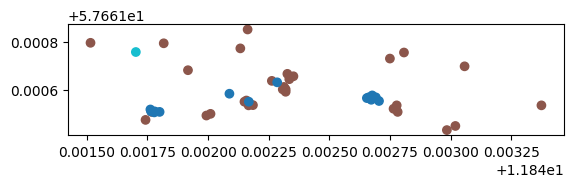

In [25]:
cluster_of_interest_id = 28
ax = origins[origins['cluster']==cluster_of_interest_id].plot( column='ShipType')


最后我们可以绘制轨迹信息和图中各个轨迹起点聚类的中心。

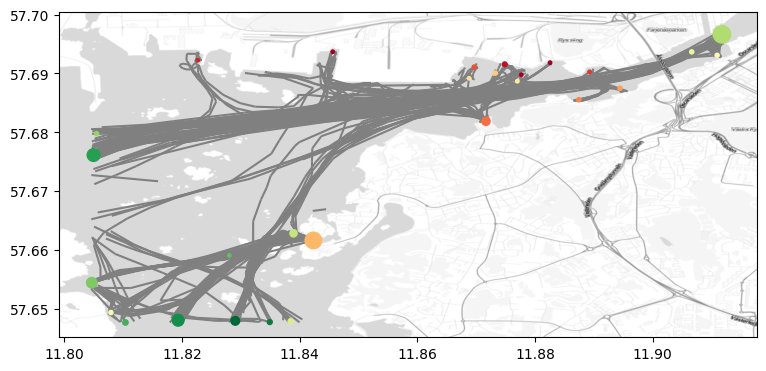

In [26]:
 fig, ax = plt.subplots(figsize=(9, 6))
ax = trips.plot(ax=ax, color='gray', line_width=1) 
# 添加簇中心
ax = GeoDataFrame(summary,crs=df_crs).plot(ax=ax, column='sog', cmap='RdYlGn', markersize=summary['n'].values*3,zorder=2)
# 添加背景地图,zoom越大越精细，这里使用自适应zoom。
cx.add_basemap(ax = ax , source=cx.providers.Stamen.TonerLite,crs=my_traj.df.crs, zoom='auto',attribution="")
cx.add_basemap(ax = ax , source=cx.providers.Stamen.TonerLabels,crs=my_traj.df.crs, zoom='auto',attribution="")
# 保存图片
fig.savefig("res.jpg",dpi=300)

# 2 马颈圈数据分析示例

马颈圈Horse collar是一种用于驯服和控制马匹的装置。它通常是由皮革、尼龙或其他坚固材料制成的环状物，以围绕马的颈部。马颈圈的设计目的是使马匹更容易受到驾驭者的控制并按照驾驭者的指示移动。本章基于哥本哈根大学和丹麦某市政技术与环境中心提供的马颈圈跟踪数据进行马匹行为分析，其分析方法可用于其他类似数据集。

**step1数据导入**



加载数据，并删除不需要的列。

In [27]:
df = read_file('data/horse_collar.gpkg')
df['t'] = pd.to_datetime(df['timestamp'])
df = df.set_index('t').tz_localize(None)
# 去除不使用的列
df = df.drop(columns=['LMT_Date', 'LMT_Time',
       'Origin', 'SCTS_Date', 'SCTS_Time', 'Latitude [?]', 'Longitude [?]',
       'FixType', 'Main [V]', 'Beacon [V]', 'Sats', 'Sat',
       'C/N', 'Sat_1', 'C/N_1', 'Sat_2', 'C/N_2', 'Sat_3', 'C/N_3', 'Sat_4',
       'C/N_4', 'Sat_5', 'C/N_5', 'Sat_6', 'C/N_6', 'Sat_7', 'C/N_7', 'Sat_8',
       'C/N_8', 'Sat_9', 'C/N_9', 'Sat_10', 'C/N_10', 'Sat_11', 'C/N_11',
       'Easting', 'Northing',], axis=1)

# 查看数据
# No: 每条记录的序号。
# CollarID: 马颈圈的唯一标识符，每一个马颈圈代表一匹马
# UTC_Date: 记录数据的日期，使用世界协调时间（UTC）标准表示。
# UTC_Time: 记录数据的时间，使用世界协调时间（UTC）标准表示。
# lat: 数据点的纬度信息。
# long: 数据点的经度信息。
# Mort. Status: 
# Temp [?C]: 马颈圈数据点的温度。
# Activity: 马颈圈数据点的活动级别。
# timestamp: 记录数据的时间戳。
# geometry: 马颈圈数据点的GeoPandas位置几何信息。
df.head()

,No,CollarID,UTC_Date,UTC_Time,lat,long,Mort. Status,Temp [?C],Activity,timestamp,geometry
t,,,,,,,,,,,
2018-11-14 12:01:08,299,30788,14-11-2018,12:01:08,54.743331,11.916987,NaN,22.0,NaN,2018-11-14 12:01:08,POINT (687757.574 6070134.334)
2018-11-14 12:15:09,300,30788,14-11-2018,12:15:09,54.676884,11.910876,NaN,22.0,NaN,2018-11-14 12:15:09,POINT (687671.088 6062727.428)
2018-11-14 12:30:08,301,30788,14-11-2018,12:30:08,54.627018,11.957852,NaN,21.0,NaN,2018-11-14 12:30:08,POINT (690932.614 6057307.716)
2018-11-14 13:00:33,302,30788,14-11-2018,13:00:33,54.625893,11.953686,NaN,17.0,NaN,2018-11-14 13:00:33,POINT (690669.038 6057171.248)
2018-11-14 13:30:09,303,30788,14-11-2018,13:30:09,54.626171,11.954280,NaN,17.0,NaN,2018-11-14 13:30:09,POINT (690706.056 6057203.814)


In [28]:
# 查看数据维度
df.shape

(17517, 11)

In [29]:
# 查看数据的坐标系
original_crs  = df.crs
original_crs 

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
#　只有一个马颈圈标识符
print(df['CollarID'].unique())
collar_id = df['CollarID'].unique()[0]

[30788]


In [31]:
# 只有一个马颈圈运行状态
df['Activity'].unique()


array([nan])

**step2 数据概览**

该步主要检查数据是否符合逻辑。

**位置概览**

马颈圈数据集个数据点的坐标应该比较接近。按照这一规则，可以删除位置离群点。

<Axes: >

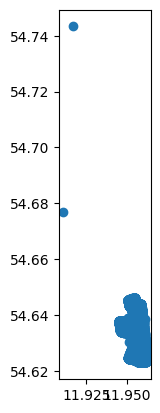

In [32]:
# EPSG:4326是常用的经纬度坐标系WGS84
df.to_crs({'init': 'EPSG:4326'}).plot()

我们可以看到有两个马颈圈的坐标和其他马颈圈的坐标相隔较远，需要删除这两项数据以删除离群数据。

In [33]:
# 将数据按照数据点经度从小到大排列
# 经度最高的两个点即为离群点
df.sort_values('lat').tail(2)


,No,CollarID,UTC_Date,UTC_Time,lat,long,Mort. Status,Temp [?C],Activity,timestamp,geometry
t,,,,,,,,,,,
2018-11-14 12:15:09,300,30788,14-11-2018,12:15:09,54.676884,11.910876,NaN,22.0,NaN,2018-11-14 12:15:09,POINT (687671.088 6062727.428)
2018-11-14 12:01:08,299,30788,14-11-2018,12:01:08,54.743331,11.916987,NaN,22.0,NaN,2018-11-14 12:01:08,POINT (687757.574 6070134.334)


按照这种方式删除这两个离群点。

In [34]:
df = df.sort_values('lat')[:-2]
# 按照编号排序
df = df.sort_values('No')
df.head()

,No,CollarID,UTC_Date,UTC_Time,lat,long,Mort. Status,Temp [?C],Activity,timestamp,geometry
t,,,,,,,,,,,
2018-11-14 12:30:08,301,30788,14-11-2018,12:30:08,54.627018,11.957852,NaN,21.0,NaN,2018-11-14 12:30:08,POINT (690932.614 6057307.716)
2018-11-14 13:00:33,302,30788,14-11-2018,13:00:33,54.625893,11.953686,NaN,17.0,NaN,2018-11-14 13:00:33,POINT (690669.038 6057171.248)
2018-11-14 13:30:09,303,30788,14-11-2018,13:30:09,54.626171,11.954280,NaN,17.0,NaN,2018-11-14 13:30:09,POINT (690706.056 6057203.814)
2018-11-14 14:00:38,304,30788,14-11-2018,14:00:38,54.626167,11.954662,NaN,17.0,NaN,2018-11-14 14:00:38,POINT (690730.771 6057204.431)
2018-11-14 14:30:08,305,30788,14-11-2018,14:30:08,54.626427,11.955650,NaN,18.0,NaN,2018-11-14 14:30:08,POINT (690793.288 6057235.998)


绘制删除离群点后的数据。

<Axes: >

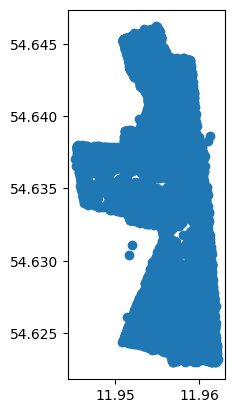

In [35]:
df.to_crs({'init': 'EPSG:4326'}).plot()

最后我们可以大体计算马群活动面积。

In [36]:
temp = df.to_crs(original_crs)
# 膨胀数据
# 对temp DataFrame中的几何对象进行缓冲处理。
# 对geometry列中的每个几何对象应用buffer(5)，即在每个几何对象周围创建一个半径为5的缓冲区。
temp['geometry'] = temp['geometry'].buffer(5)
# dissolve将所有项按照CollarID列的信息合并
# area计算面积，original_crs使用的单位是米，那么这里面积的单位应该是平方米
total_area = temp.dissolve(by='CollarID').area 
# 将平方米转换为平方公顷(平方百米)
total_area = total_area[collar_id]/10000
print("数据覆盖的总面积为: {:,.2f} 公顷".format(total_area))

数据覆盖的总面积为: 65.19 公顷


**时间概览**

In [37]:
# 查看数据点的时间范围
print("数据点的时间范围为 {} 到 {}.".format(df.index.min(), df.index.max()))

数据点的时间范围为 2018-11-14 12:30:08 到 2019-11-07 05:30:10.


In [38]:
# 查看数据点的时间跨度
print("数据点的时间跨度为 {}".format(df.index.max() - df.index.min()))

数据点的时间跨度为 357 days 17:00:02


In [39]:
# 统计每一天的马颈圈数据
df['No'].resample('1d').count()

t
2018-11-14    23
2018-11-15    66
2018-11-16    58
2018-11-17    70
2018-11-18    79
              ..
2019-11-03    48
2019-11-04    48
2019-11-05    48
2019-11-06    48
2019-11-07    12
Freq: D, Name: No, Length: 359, dtype: int64

<Axes: xlabel='t'>

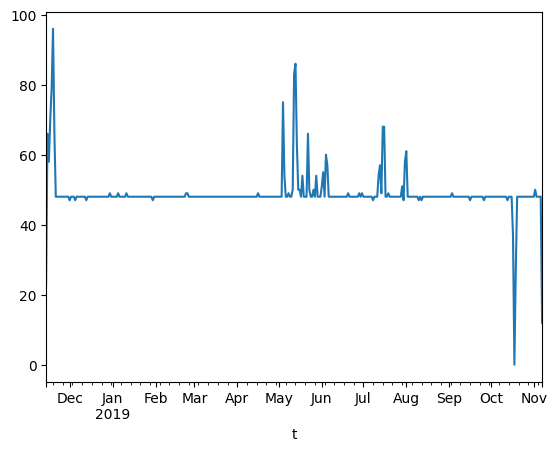

In [40]:
# 可视化数据量
df['No'].resample('1d').count().plot()

此外，也可以进一步统计各个月份的样本数，代码如下：

In [41]:
# 添加年份-月份列
df['Y-M'] = df.index.to_period('M')    
for i in df['Y-M'].unique():
    print("时间{}，样本数{}".format(i,len(df[df['Y-M']==i])))

时间2018-11，样本数938
时间2018-12，样本数1486
时间2019-01，样本数1489
时间2019-02，样本数1346
时间2019-03，样本数1488
时间2019-04，样本数1441
时间2019-05，样本数1650
时间2019-06，样本数1474
时间2019-07，样本数1556
时间2019-08，样本数1499
时间2019-09，样本数1439
时间2019-10，样本数1407
时间2019-11，样本数302


**step3 数据分析**

**采样间隔分析**

对于数据的采样，很重要的一点是确定数据是否为间隔采样。如果是间隔采样，那么采样间隔是多少？

In [42]:
# 重置索引并提取't'列
t = df.reset_index()['t']
# 计算时间间隔，当每一项数据与前一项数据的时间差
df['delta_t'] = t.diff().values
# 将时间间隔转换为分钟
df['delta_t'] = df['delta_t'].dt.total_seconds() / 60
df['delta_t']

t
2018-11-14 12:30:08          NaN
2018-11-14 13:00:33    30.416667
2018-11-14 13:30:09    29.600000
2018-11-14 14:00:38    30.483333
2018-11-14 14:30:08    29.500000
                         ...    
2019-11-07 03:30:38    30.466667
2019-11-07 04:00:09    29.516667
2019-11-07 04:30:08    29.983333
2019-11-07 05:00:10    30.033333
2019-11-07 05:30:10    30.000000
Name: delta_t, Length: 17515, dtype: float64

如下绘制时间间隔柱状图，查看时间间隔集中哪个值。结果是采样方式为均匀采样，采样间隔通常在30分钟左右。

<Axes: >

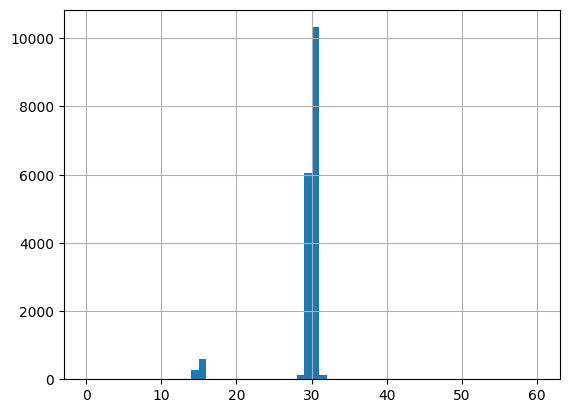

In [43]:
# 绘制时间间隔柱状图
# bins=60表示将数据范围划分成60个等宽的区间，每一个bin表示一个分钟
#range=(0, 60)表示设置直方图显示的数据范围在0到60之间。
df['delta_t'].hist(bins=60, range=(0, 60))

**运动速度和方向分析**

通过最大运动速度判断数据中是否包含无法达到的速度。

In [44]:
# 'CollarID'只有一个，所以轨迹只有一个
tc = mpd.TrajectoryCollection(df, 'CollarID')
traj = tc.trajectories[0]
# 添加速度，单位是坐标系单位/s
traj.add_speed()
# 计算速度的最大值
max_speed = traj.df.speed.max()
print("The highest computed speed is {:,.2f} m/s ({:,.2f} km/h)".format(max_speed, max_speed*3600/1000))

The highest computed speed is 0.82 m/s (2.94 km/h)


基于速度，我们可以查看速度分布，如下所示：

<Axes: >

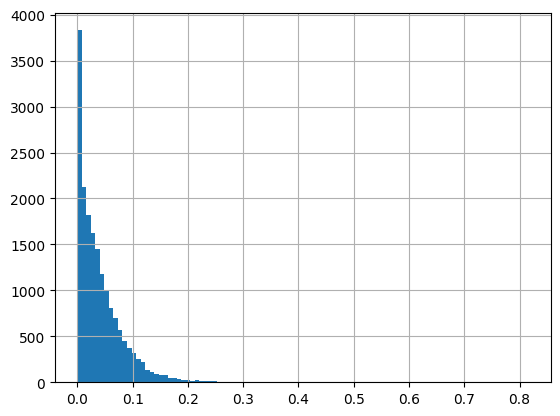

In [45]:
pd.DataFrame(traj.df)['speed'].hist(bins=100)

进而，我们也可以分析运动方向分布。

<Axes: >

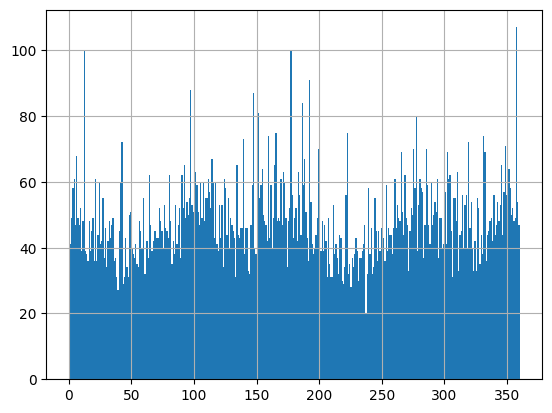

In [46]:
traj.add_direction(overwrite=True)
pd.DataFrame(traj.df)['direction'].hist(bins=360)

**时间趋势分析**

如果我们想了解马匹运动趋势与时间的关系，可以通过如下代码实现。

In [47]:
# 分析时间和速度的关系
tmp = pd.DataFrame(traj.df)[['speed']]
tmp = tmp.reindex(pd.DataFrame(traj.df).index)
# 生成小时和月份列
tmp["hour"] = tmp.index.hour
tmp["month"] = tmp.index.month
tmp.head()

,speed,hour,month
t,,,
2018-11-14 12:30:08,0.162635,12,11
2018-11-14 13:00:33,0.162635,13,11
2018-11-14 13:30:09,0.027761,13,11
2018-11-14 14:00:38,0.013517,14,11
2018-11-14 14:30:08,0.039568,14,11


然后我们可以汇总不同月份不同小时下马匹平均速度。结果发现一年中按小时划分的运动速度表现出明显的不同，马匹夏季的运动较早且时间跨度大，冬季的运动较晚且时间跨度小。

<Axes: xlabel='month', ylabel='hour'>

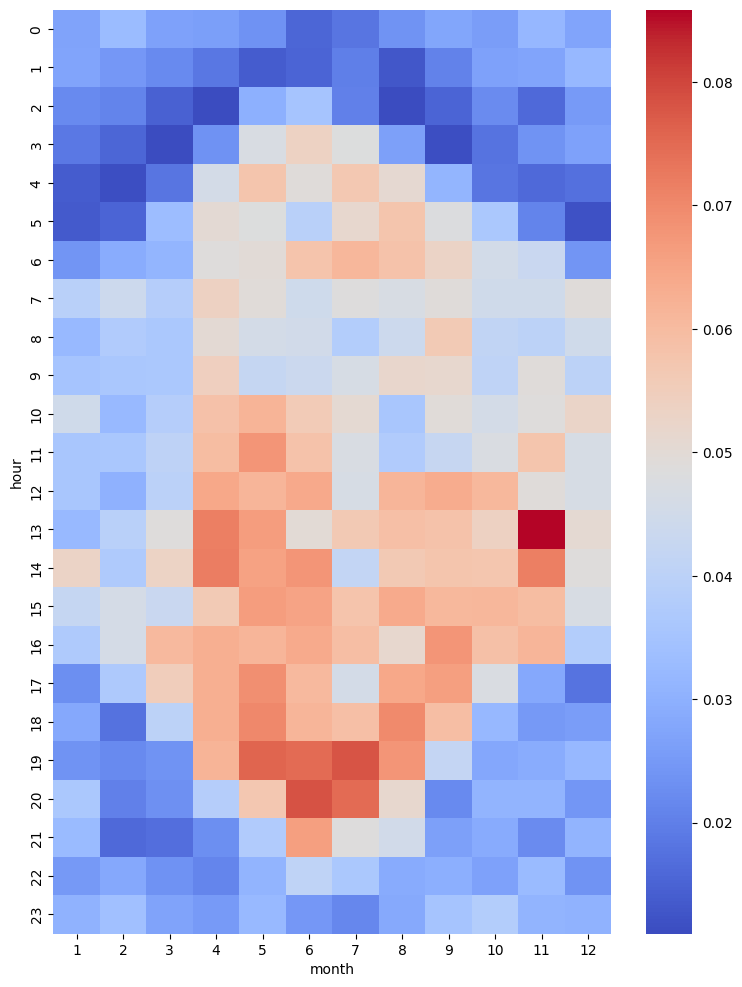

In [48]:
# 使用pivot_table函数计算平均速度在不同小时和月份的汇总数据
pivot_table = tmp.pivot_table(values='speed', index='hour', columns='month', aggfunc='mean')
# 创建热图
plt.figure(figsize=(9, 12))
# 横轴表示月份，纵轴表示小时，
sns.heatmap(pivot_table, annot=False, cmap='coolwarm')

**温度趋势分析**

除了时间，数据集还包含每个记录的温度信息，我们也可以对温度进行分析。

In [49]:
# 分析温度和速度的关系
tmp = pd.DataFrame(traj.df)[['Temp [?C]', 'speed']]
tmp = tmp.reindex(pd.DataFrame(traj.df).index)
# 生成月份列
tmp["month"] = tmp.index.month
tmp.head()

,Temp [?C],speed,month
t,,,
2018-11-14 12:30:08,21.0,0.162635,11
2018-11-14 13:00:33,17.0,0.162635,11
2018-11-14 13:30:09,17.0,0.027761,11
2018-11-14 14:00:38,17.0,0.013517,11
2018-11-14 14:30:08,18.0,0.039568,11


如上数据所示，每一行表示某月某个时间出现某个温度一次。于此，可以新增列表示次数，但都是一次。

In [50]:

tmp['n'] = 1
tmp.head()

,Temp [?C],speed,month,n
t,,,,
2018-11-14 12:30:08,21.0,0.162635,11,1
2018-11-14 13:00:33,17.0,0.162635,11,1
2018-11-14 13:30:09,17.0,0.027761,11,1
2018-11-14 14:00:38,17.0,0.013517,11,1
2018-11-14 14:30:08,18.0,0.039568,11,1


基于温度和月份，我们可以统计每个月份每个温度出现的次数，如下所示：

<Axes: xlabel='month', ylabel='Temp [?C]'>

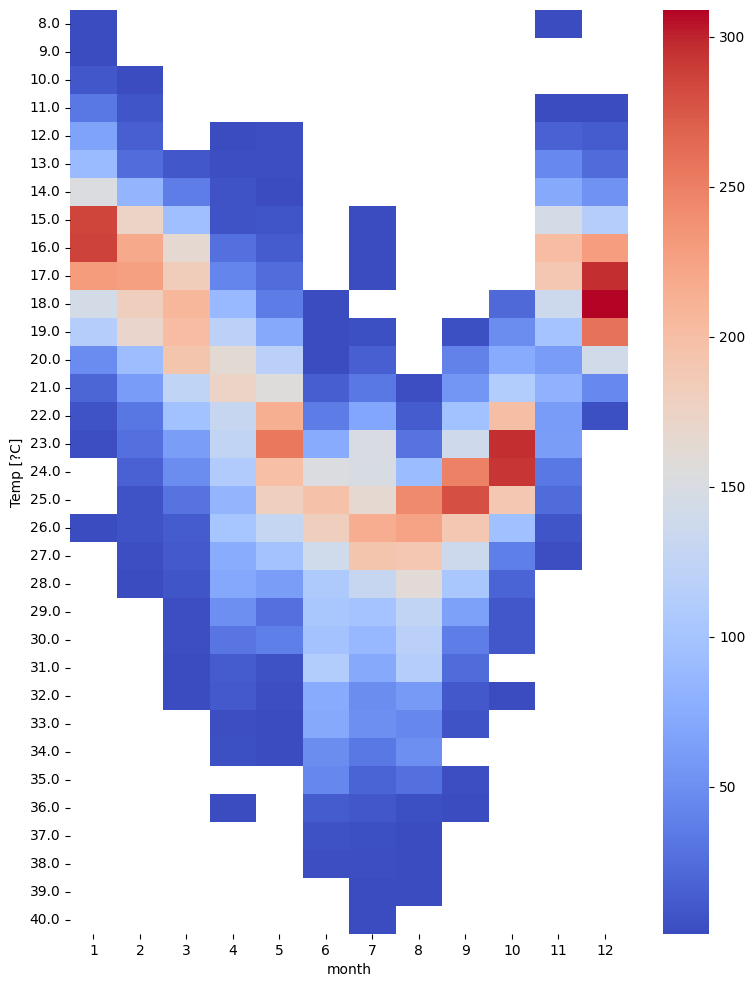

In [51]:
# 使用pivot_table函数统计不同月份下不同温度值出现次数
pivot_table = tmp.pivot_table(values='n', index='Temp [?C]', columns='month', aggfunc='sum')
# 创建热图
plt.figure(figsize=(9, 12))
# 横轴表示月份，纵轴表示温度值
sns.heatmap(pivot_table, annot=False, cmap='coolwarm')

同样我们也可以统计不同月份不同温度下速度的平均值。

<Axes: xlabel='month', ylabel='Temp [?C]'>

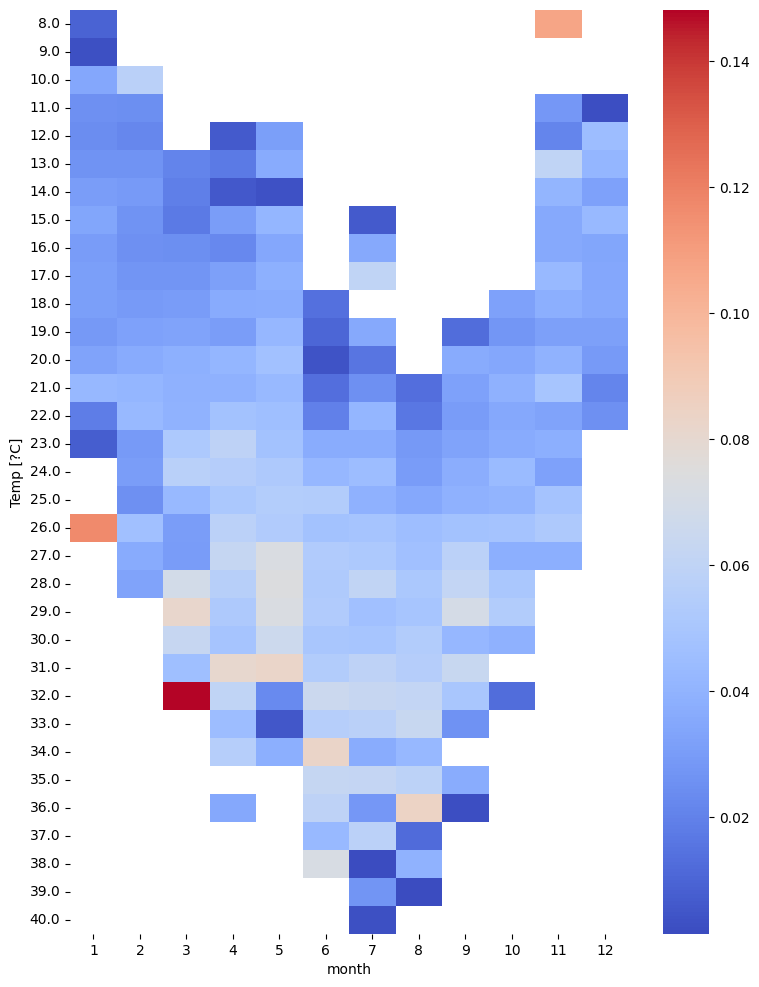

In [52]:
# 使用pivot_table函数统计不同月份下不同温度值下速度平均值
pivot_table = tmp.pivot_table(values='speed', index='Temp [?C]', columns='month', aggfunc='mean')
# 创建热图
plt.figure(figsize=(9, 12))
# 横轴表示月份，纵轴表示温度值
sns.heatmap(pivot_table, annot=False, cmap='coolwarm')

**step3 轨迹分析**

本步着眼于个体轨迹的分析。因此，需要将连续轨迹分割成单独的轨迹。分析结果取决于连续流如何划分为轨迹、位置和事件。

**轨迹长度分析**

In [53]:
# 按天为单位分割轨迹
daily = mpd.TemporalSplitter(tc).split(mode='day')
daily

TrajectoryCollection with 358 trajectories

In [54]:
# 计算每条轨迹的长度
daily_lengths = [traj.get_length() for traj in daily]
# 计算每条轨迹的开始时间
daily_t = [traj.get_start_time() for traj in daily]

In [55]:
# 建立轨迹开始时间和长度的dataframe
daily_lengths = pd.DataFrame(daily_lengths, index=daily_t, columns=['length'])
daily_lengths.head()


,length
2018-11-14 12:30:08,1090.598526
2018-11-15 00:00:08,4219.980813
2018-11-16 00:00:10,3198.209140
2018-11-17 00:00:09,4307.483500
2018-11-18 00:00:09,3548.902314


可视化轨迹开始时间和轨迹长度的关系，可以看到季节趋势与之前发现的季节运动速度模式非常一致：冬季轨迹往往比夏季轨迹短。

<Axes: >

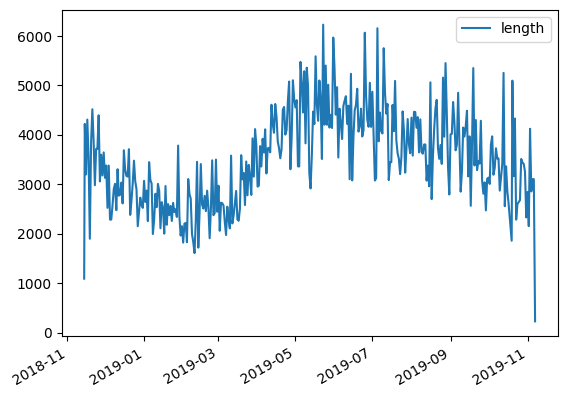

In [56]:
daily_lengths.plot()

**停留检测分析**

我们可以对某日轨迹进行单独分析，并通过停留检测以提取轨迹的停留段，如下所示：

In [57]:
# 设置最大直径为100
MAX_DIAMETER = 100

# 设置最小持续时间为3小时
MIN_DURATION = timedelta(hours=3)

# 获取指定日期（2018年11月17日）的轨迹数据，并赋值给变量one_day
one_day = daily.get_trajectory('30788_2018-11-17 00:00:00')

# 使用停留段检测器(mpd.TrajectoryStopDetector)获取指定轨迹数据的停留段，
# 并根据最小持续时间和最大直径进行筛选，结果存储在变量one_day_stops中
one_day_stops = mpd.TrajectoryStopDetector(one_day).get_stop_segments(
    min_duration=MIN_DURATION, max_diameter=MAX_DIAMETER)

绘制轨迹停留可视化结果代码如下：

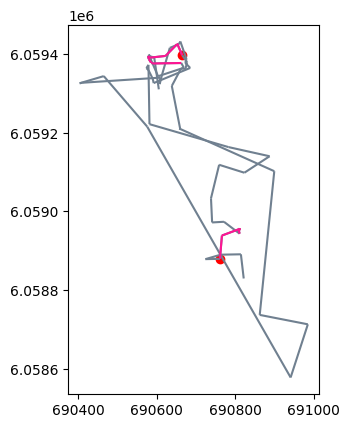

In [58]:
# 绘制轨迹
# 创建一个绘图区域(ax)，并将指定日期（one_day）的轨迹数据以灰色(slategray)进行绘制
ax = one_day.plot(color='slategray')
# 将停留段数据（one_day_stops）以深粉色(deeppink)的颜色进行绘制
ax = one_day_stops.plot(ax=ax, color='deeppink')
# 获取停留段的起始位置，并将这些起始位置以红色(red)进行绘制
ax = one_day_stops.get_start_locations().plot(ax=ax, color='red')

我们也可以对所有时间段的轨迹进行停留识别，代码如下：

In [59]:
# 获得停留轨迹点
stops = mpd.TrajectoryStopDetector(tc).get_stop_points(min_duration=MIN_DURATION, max_diameter=MAX_DIAMETER)
len(stops)

362

<Axes: >

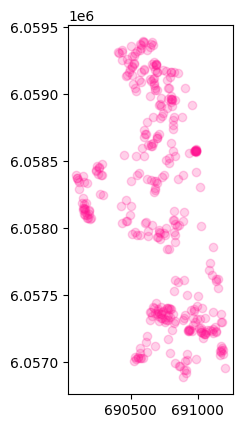

In [60]:
# 绘制这些停留的轨迹点
stops.plot(color='deeppink',alpha=0.2)


此外还可以绘制各停留时间对应的停留次数：

<Axes: >

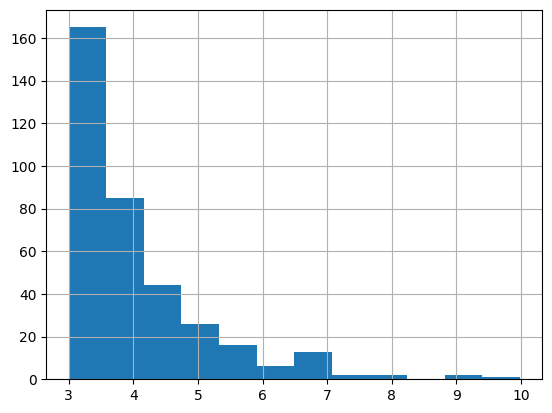

In [61]:
stops['duration_h'] = (stops['end_time']-stops['start_time']).dt.total_seconds() / 3600
# 横轴为停留时间，纵轴为停留次数
pd.DataFrame(stops)['duration_h'].hist(bins=12)

# 3 足球分析示例

本教程使用利物浦足球比赛视频片段中提取的数据，数据每一行代表利物浦队在2019年一次比赛中的一个时间点的数据。数据集下载地址为：[liverpool_2019.csv](https://raw.githubusercontent.com/Friends-of-Tracking-Data-FoTD/Last-Row/master/datasets/positional_data/liverpool_2019.csv)。


**step1 数据处理**

In [62]:
input_file = "data/liverpool_2019.csv"
df = pd.read_csv(input_file)
# 删除列
df.drop(columns=['Unnamed: 0'], inplace=True)
print("样本数",len(df))
df.tail()

样本数 74936


,bgcolor,dx,dy,edgecolor,frame,play,player,player_num,team,x,y,z
74931,blue,0.0,0.0,white,120,Leicester 0 - [3] Liverpool,10267,NaN,defense,98.724826,53.720353,0.0
74932,blue,0.0,0.0,white,121,Leicester 0 - [3] Liverpool,10267,NaN,defense,98.724826,53.720353,0.0
74933,blue,0.0,0.0,white,122,Leicester 0 - [3] Liverpool,10267,NaN,defense,98.724826,53.720353,0.0
74934,blue,0.0,0.0,white,123,Leicester 0 - [3] Liverpool,10267,NaN,defense,98.724826,53.720353,0.0
74935,blue,0.0,0.0,white,124,Leicester 0 - [3] Liverpool,10267,NaN,defense,98.724826,53.720353,0.0


所读取的数据列名解释如下：

+ play：进球后的比分情况。进球的球队位于括号旁边。
+ frame：当前位置的帧编号。提供的数据每秒有20帧。
+ player：球员的编号。此编号在一次比赛中保持一致，但在不同比赛之间可能会有变化。
+ player_num：球员的球衣号码。这个号码是官方号码，在2019年的利物浦队没有发生变化。
+ x, y：球员/足球的坐标。球场坐标在每个轴上从0到100。
+ dx, dy：从上一帧到当前帧的（x，y）坐标变化。
+ z：高度，从0到1.5（仅填充足球的高度信息）。
+ bgcolor：球队的主要颜色（用作背景色）。
+ edgecolor：辅助颜色（用作边缘颜色）。


进一步我们可以对数据进行处理，如下所示：

In [63]:
# 获取唯一plays列表
plays = list(df.play.unique())
# 获得时间戳
def to_timestamp(row):
    day = plays.index(row.play) + 1
    start_time = datetime(2019, 1, day, 12, 0, 0)
    # 将frame转换为时间戳
    td = timedelta(milliseconds=1000 / 20 * row.frame)
    return start_time + td

# 将frame转换为时间戳，并添加到DataFrame的新列'time'中
df['time'] = df.apply(to_timestamp, axis=1)
# 将'time'列设为索引，以便后续使用时间作为索引来访问数据
df.set_index('time', inplace=True)

# 根据足球场地的标准尺寸，将x和y坐标缩放到合适的范围
# 许多职业球队的足球场地标准尺寸为105米乘以68米
pitch_length = 105
pitch_width = 68
df.x = df.x / 100 * pitch_length 
df.y = df.y / 100 * pitch_width

# 将以下列转化为分类数据
df['team'] = df['team'].astype('category').cat.as_ordered()
df['player'] = df['player'].astype('category').cat.as_ordered()
df['player_num'] = df['player_num'].astype('category').cat.as_ordered()

df.tail()

,bgcolor,dx,dy,edgecolor,frame,play,player,player_num,team,x,y,z
time,,,,,,,,,,,,
2019-01-19 12:00:06.000,blue,0.0,0.0,white,120,Leicester 0 - [3] Liverpool,10267,NaN,defense,103.661067,36.52984,0.0
2019-01-19 12:00:06.050,blue,0.0,0.0,white,121,Leicester 0 - [3] Liverpool,10267,NaN,defense,103.661067,36.52984,0.0
2019-01-19 12:00:06.100,blue,0.0,0.0,white,122,Leicester 0 - [3] Liverpool,10267,NaN,defense,103.661067,36.52984,0.0
2019-01-19 12:00:06.150,blue,0.0,0.0,white,123,Leicester 0 - [3] Liverpool,10267,NaN,defense,103.661067,36.52984,0.0
2019-01-19 12:00:06.200,blue,0.0,0.0,white,124,Leicester 0 - [3] Liverpool,10267,NaN,defense,103.661067,36.52984,0.0


得到了数据后，可以转换为轨迹：

In [64]:
CRS = None
tc = mpd.TrajectoryCollection(df, 'player', x='x', y='y', crs=CRS)
tc 

TrajectoryCollection with 364 trajectories

**轨迹分析**

我们可以对单个球员的轨迹进行分析，代码如下所示：

In [65]:
# 获得球员轨迹
PLAY = 2
play_trajs = tc.filter('play', plays[PLAY])
play_trajs

TrajectoryCollection with 20 trajectories

<Axes: >

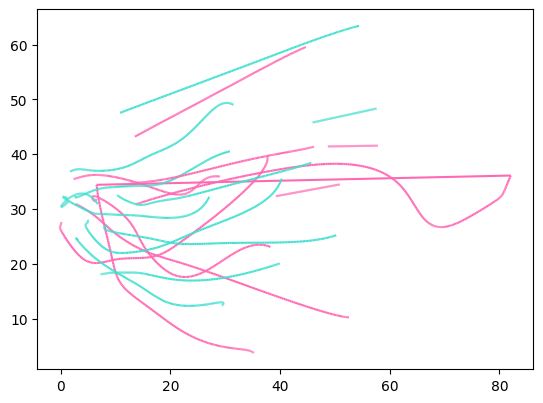

In [66]:
# 绘制其进攻或防守轨迹
play_trajs.plot(column='team', colormap={'attack':'hotpink', 'defense':'turquoise'})

<Axes: >

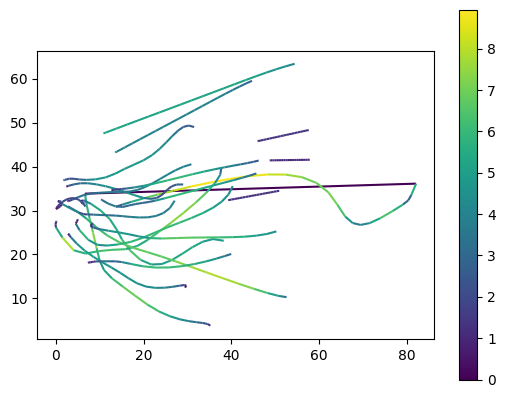

In [67]:
# 简化轨迹
generalized = mpd.MinTimeDeltaGeneralizer(play_trajs).generalize(tolerance=timedelta(seconds=0.5))
generalized.add_speed()
# 绘制轨迹速度
generalized.plot(column='speed',legend=True)


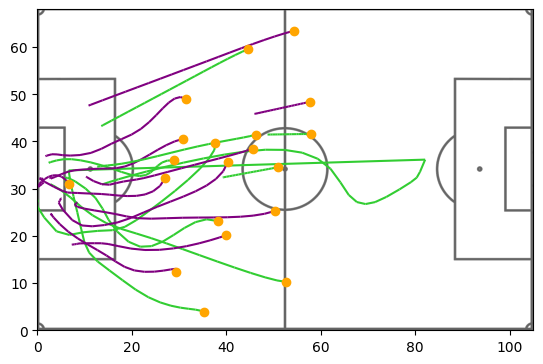

In [68]:
# 添加完整轨迹数据
ax = generalized.plot(column='team', colormap={'attack':'limegreen', 'defense':'purple'})
ax = generalized.get_start_locations().plot(ax = ax ,label='start', color='orange',zorder=2)
import matplotlib.image as mpimg

# 添加背景图片
# 下载地址https://github.com/movingpandas/movingpandas/raw/main/tutorials/data/soccer_field.png
img = mpimg.imread('data/soccer_field.png')
ax.imshow(img, extent=[0, pitch_length, 0, pitch_width])

# 4 参考

+ [MovingPandas入门指北](https://www.cnblogs.com/luohenyueji/p/17602916.html)
+ [liverpool_2019.csv](https://raw.githubusercontent.com/Friends-of-Tracking-Data-FoTD/Last-Row/master/datasets/positional_data/liverpool_2019.csv)
+ [movingpandas](https://github.com/movingpandas/movingpandas)
+ [movingpandas-examples](https://github.com/movingpandas/movingpandas-examples)
+ [movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)
+ [GeoPandas叠加背景地图](https://www.cnblogs.com/luohenyueji/p/17485432.html#5-%E8%83%8C%E6%99%AF%E5%9C%B0%E5%9B%BE%E5%8F%A0%E5%8A%A0)